# EDA : Exploratory Data Analysis 

In [1]:
# Nous avons besoins d'importer quelques modules 
import pandas as pd 
import numpy as np 
import geopandas as gpd 
import matplotlib.pyplot as plt 
import folium
import seaborn as sns
import requests 
import re
import os
from datetime import datetime
import plotly.express as px
import time

## Visualisons les bornes de recharge pour les véhicules électriques en France

Le jeu de données que nous allons utiliser date du 23 juillet 2023, vous pouvez le retrouver sur cette [page](https://www.data.gouv.fr/fr/datasets/bornes-de-recharge-pour-vehicules-electriques-3/).

In [2]:
# On commence par récupérer notre data set 
URL = 'https://www.data.gouv.fr/fr/datasets/r/517258d5-aee7-4fa4-ac02-bd83ede23d25'
df = pd.read_csv(URL, sep = ';')

In [3]:
df.sample(5)

,n_amenageur,n_operateur,n_enseigne,id_station,n_station,ad_station,code_insee,xlongitude,ylatitude,nbre_pdc,...,type_prise,acces_recharge,accessibilite,observations,date_maj,source,geo_point_borne,code_insee_commune,region,departement
2616,SYANE,SYANE,E Born,FR*S74*P74121*A,EXCENEVEX_Avenue de la Plage,Avenue de la Plage 74140 EXCENEVEX,74121.0,6.358175,46.346000,NaN,...,E/F + T2,Payant,24/24 7/7 jours,NaN,2020-03-24,https://www.data.gouv.fr/fr/datasets/syane-bor...,"46.3459998,6.3581754",74121,Auvergne-Rhône-Alpes,Haute-Savoie
10506,Ville d'Hazebrouck,BOUYGUES ENERGIES ET SERVICES,pass pass électrique,FR*H08*P59295*001,HAZEBROUCK - Rue de la plaine,Rue de la plaine 59190 HAZEBROUCK,59295.0,2.552611,50.730270,2.0,...,EF - T2,payant,24h/24 7j/7,Recharge par badge et avec une application sma...,2020-04-03,https://www.data.gouv.fr/fr/datasets/infrastru...,"50.73027,2.552611",59295,Hauts-de-France,Nord
4420,Mairie de Paris,Mairie de Paris,Paris Recharge,FR*W75*PVP*0089,110 BOULEVARD RICHARD LENOIR,"110 BOULEVARD RICHARD LENOIR, 75011 PARIS",75111.0,2.371399,48.864062,6.0,...,prise T3,payant,7/7-24/24,Courant: AC mono|tarif: 120€/an|https://www.pa...,2020-07-22,https://www.data.gouv.fr/fr/datasets/paris-rec...,"48.8640621,2.3713985",75056,Île-de-France,Paris
9756,TOTAL MARKETING FRANCE,TOTAL MARKETING FRANCE,Belib',FR*V75*PPX11*08,Paris | Boulevard Richard Lenoir 36,"36 Boulevard Richard Lenoir, 75011 Paris",75111.0,2.371390,48.857258,4.0,...,T2-EF,payant,7/7-24/24,https://belib.paris,2021-06-02,https://www.data.gouv.fr/fr/datasets/belib-poi...,"48.857258,2.37139",75056,Île-de-France,Paris
1702,SDE76,Sodetrel,SDE76,FR*SOD*P*SDE7*79*_*_*_,Trouville-Alliquerville,Route de l'Eglise,76715.0,0.527887,49.584935,2.0,...,E/F-T2,payant,24/24 7/7,RFID et application,2018-04-11,https://www.data.gouv.fr/fr/datasets/bornes-de...,"49.584935,0.527887",76382,Normandie,Seine-Maritime


### Catégories d'accès à la borne : 

Comme l'illustre la cellule de code suivante, les catégories proposées ne sont pas très propres. Remédions à cela.

In [4]:
list(df['acces_recharge'].unique())

[nan,
 'Gratuit',
 'Payant',
 'payant',
 'gratuit',
 'oui',
 '5€ / 45min, si abonné (10€/mois) : 1€/10min',
 'Réservation préalable, accès par badge',
 '0.19€/kWh + 0.01€/min',
 'Public payant',
 'QR code / appli mobile / Carte RFID',
 'gratuit pour la clientèle du parking',
 'badge RFID; QR Code',
 'Charges gratuites de 12 à 14h et de 19h à 21h',
 'Payant (badge, appli et QR code)',
 'GRATUIT',
 '2€/recharge',
 'Carte Mobive',
 'Accès payant (Badge RFID, application, site web paynow.sodetrel.fr, badges vendus en boutique)',
 '2€/recharge+ prix du stationnement']

In [5]:
def transform_acces(row):
    if not pd.isna(row):  # On ne peut rien dire des nan
        row = row.lower()  # Mettre en lettre minuscule 
        mots = row.split(' ')
        if 'payant' in mots: row = 'payant'
        elif 'gratuit' in mots: row = 'gratuit'
        for mot in mots: 
            if len(mot.split('€'))>1: row = 'payant'
            if mot=='carte' or mot=='badge': row = 'carte ou badge'
            if mot=='oui': row = 'information manquante'
        #else: row = 'accès spécial'
    else: row = 'information manquante'
    return row
df['acces_recharge'] = df['acces_recharge'].apply(transform_acces)
list(df['acces_recharge'].unique())

['information manquante',
 'gratuit',
 'payant',
 'carte ou badge',
 'charges gratuites de 12 à 14h et de 19h à 21h']

### On veut ensuite s'assurer que nous disposons de toutes les informations concernant les coordonénes géographiques des bornes de recharge ... 

Il y a  30 valeurs manquantes pour xlongitude
Il y a  6 valeurs manquantes pour ylatitude


<Axes: >

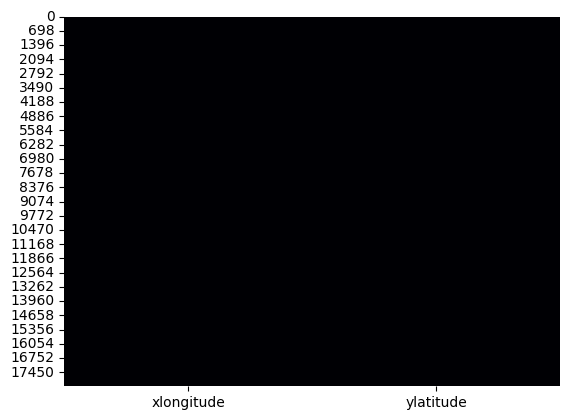

In [6]:
print('Il y a ', df[df['xlongitude'].isna()].shape[0], 'valeurs manquantes pour xlongitude')
print('Il y a ', df[df['ylatitude'].isna()].shape[0], 'valeurs manquantes pour ylatitude')
sns.heatmap(df[['xlongitude', 'ylatitude']].isna(), cmap = 'magma', cbar = False)

In [7]:
droping_liste = list(set(df[df['xlongitude'].isna()].index.to_list() + df[df['ylatitude'].isna()].index.to_list()))
df.drop(droping_liste, inplace = True)

### Regardons plus attentivement la répartition des bornes en France